# **LoRA FINE-TUNING OF FLAN T5 BASE MODEL ON PINTEREST KEYWORD GENERATION**

# 1. Model Training

## 1.1 Installing Dependencies

In [ ]:
# First, uninstall conflicting packages and install compatible versions
!pip uninstall -y torch torchvision torchaudio transformers accelerate -q
!pip install torch==2.4.0 transformers==4.44.0 datasets==2.20.0 accelerate==0.33.0 scikit-learn -q

# Restart runtime after installation
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1.2 Importing Packages

In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup,
    DataCollatorForSeq2Seq
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    prepare_model_for_kbit_training
)
from google.colab import drive
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Dict, Tuple
import re
import warnings
warnings.filterwarnings('ignore')

## 1.3 Configuration Class for LoRA Fine Tuning

In [ ]:
class Config:
    """LoRA-optimized configuration for small dataset fine-tuning"""

    # Model settings
    MODEL_NAME = "google/flan-t5-base"

    MAX_INPUT_LEN = 256
    MAX_TARGET_LEN = 256

    # Training settings
    BATCH_SIZE = 4
    GRADIENT_ACCUMULATION_STEPS = 4
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 85
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01

    LORA_R = 16
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.1
    LORA_TARGET_MODULES = ["q", "v", "k", "o", "wi", "wo"]

    # Generation settings
    TEMPERATURE = 0.8
    TOP_P = 0.95
    NUM_BEAMS = 6
    REPETITION_PENALTY = 1.8
    LENGTH_PENALTY = 1.1

    # Learning rate scheduling
    LR_SCHEDULER = "cosine"
    MIN_LR = 1e-6

    DRIVE_PATH = "/content/drive/MyDrive"
    MODEL_SAVE_PATH = f"{DRIVE_PATH}/pinterest-flan-t5-lora-improved-dataset"
    DATASET_PATH = "dataset.json"

    SEED = 42
    PATIENCE = 10


## 1.4 Utility Functions

In [ ]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def mount_drive():
    """Mount Google Drive"""
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully")
    except:
        print("⚠️ Could not mount Google Drive. Saving locally.")


## 1.5 Dataset Class

In [ ]:
class PinterestPersonalityDataset(Dataset):
    """Dataset for Pinterest personality keywords generation"""

    def __init__(self, data, tokenizer, config, max_input_len=128, max_target_len=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len
        self.config = config

    def __len__(self):
        return len(self.data)

    def _create_enhanced_input(self, item):
        """Create more informative input text"""
        name = item['name']
        culture = item.get('culture_region', '')
        role = item.get('role', '')
        period = item.get('time_period', '')
        bio = item.get('bio', '')

        input_parts = [
            f"Generate Pinterest keywords for {name}",
        ]

        context_parts = []
        if culture:
            context_parts.append(f"Culture: {culture}")
        if role:
            context_parts.append(f"Role: {role}")
        if period:
            context_parts.append(f"Period: {period}")
        if bio:
          context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        return " - ".join(input_parts)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_text = self._create_enhanced_input(item)
        target_text = item['target_text']

        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.config.MAX_INPUT_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.config.MAX_TARGET_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels
        }


## 1.6 Evaluation Metrics

In [ ]:
class PinterestEvaluator:
    """Evaluate the quality of generated Pinterest keywords"""

    def __init__(self):
        self.visual_terms = [
            'aesthetic', 'style', 'color', 'texture', 'pattern', 'design',
            'art', 'visual', 'mood', 'vibe', 'look', 'fashion', 'decor',
            'palette', 'tone', 'hue', 'shade', 'photography', 'image'
        ]

        self.pinterest_terms = [
            'board', 'pin', 'inspiration', 'diy', 'craft', 'vintage',
            'rustic', 'minimalist', 'boho', 'chic', 'glam', 'cozy',
            'aesthetic', 'mood', 'vibe', 'style', 'ideas', 'inspo'
        ]

    def calculate_keyword_diversity(self, keywords_list: List[str]) -> float:
        """Calculate diversity score for generated keywords"""

        all_keywords = []
        for keywords in keywords_list:
            all_keywords.extend([k.strip() for k in keywords.split(',')])

        unique_keywords = set(all_keywords)
        diversity_score = len(unique_keywords) / len(all_keywords) if all_keywords else 0

        return diversity_score

    def evaluate_quality(self, generated_text: str) -> Dict[str, float]:
        """Evaluate the Pinterest-specific quality of generated keywords"""

        keywords = [k.strip().lower() for k in generated_text.split(',')]

        # Visual score
        visual_score = sum(1 for keyword in keywords
                          for term in self.visual_terms if term in keyword) / len(keywords)

        # Pinterest score
        pinterest_score = sum(1 for keyword in keywords
                             for term in self.pinterest_terms if term in keyword) / len(keywords)

        # Length and diversity
        avg_keyword_length = np.mean([len(k) for k in keywords])
        keyword_diversity = len(set(keywords)) / len(keywords)

        return {
            'visual_score': visual_score,
            'pinterest_score': pinterest_score,
            'avg_keyword_length': avg_keyword_length,
            'keyword_diversity': keyword_diversity,
            'total_keywords': len(keywords)
        }

## 1.7 LoRA Training Class

In [ ]:
class PinterestLoRATrainer:
    """LoRA training class for Pinterest keyword generation"""

    def __init__(self, config: Config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.evaluator = PinterestEvaluator()

        print(f"Loading base model: {config.MODEL_NAME}")
        self.tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
        self.base_model = AutoModelForSeq2SeqLM.from_pretrained(
            config.MODEL_NAME,
            torch_dtype=torch.float32
        ).to(self.device)

        lora_config = LoraConfig(
            r=config.LORA_R,
            lora_alpha=config.LORA_ALPHA,
            target_modules=config.LORA_TARGET_MODULES,
            lora_dropout=config.LORA_DROPOUT,
            bias="none",
            task_type=TaskType.SEQ_2_SEQ_LM,
        )

        self.model = get_peft_model(self.base_model, lora_config)

        self.model.print_trainable_parameters()

        print(f"✅ LoRA model loaded with {self.count_parameters():,} trainable parameters")

    def count_parameters(self):
        """Count trainable parameters"""
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def prepare_data(self, data_path: str) -> Tuple[List[Dict], List[Dict]]:
        """Load and prepare the dataset"""

        print("\n📂 Loading dataset...")
        with open(data_path, 'r') as f:
            data = json.load(f)

        print(f"Loaded {len(data)} personalities")

        cleaned_data = self._validate_data(data)

        train_data, val_data = train_test_split(
            cleaned_data,
            test_size=0.15,
            random_state=self.config.SEED
        )

        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")

        return train_data, val_data

    def _validate_data(self, data: List[Dict]) -> List[Dict]:
        """Validate and clean the dataset"""

        cleaned_data = []
        required_fields = ['name', 'target_text']

        for item in data:
            if all(field in item for field in required_fields):
                cleaned_item = {}
                for key, value in item.items():
                    if isinstance(value, str):
                        cleaned_item[key] = value.strip()
                    else:
                        cleaned_item[key] = value

                keywords = [k.strip() for k in cleaned_item['target_text'].split(',') if k.strip()]
                cleaned_item['target_text'] = ', '.join(keywords)

                cleaned_item.setdefault('culture_region', '')
                cleaned_item.setdefault('role', '')
                cleaned_item.setdefault('time_period', '')

                cleaned_data.append(cleaned_item)

        return cleaned_data

    def train(self, train_data: List[Dict], val_data: List[Dict]):
        """Main LoRA training loop"""

        # datasets
        train_dataset = PinterestPersonalityDataset(train_data, self.tokenizer, self.config)
        val_dataset = PinterestPersonalityDataset(val_data, self.tokenizer, self.config)

        # data collator
        data_collator = DataCollatorForSeq2Seq(
            self.tokenizer,
            model=self.model,
            label_pad_token_id=-100
        )

        # dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            collate_fn=data_collator,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.BATCH_SIZE,
            collate_fn=data_collator,
            pin_memory=True
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY,
            eps=1e-8,
            betas=(0.9, 0.999)
        )

        # Learning rate scheduler
        total_steps = len(train_loader) * self.config.NUM_EPOCHS // self.config.GRADIENT_ACCUMULATION_STEPS
        warmup_steps = int(total_steps * self.config.WARMUP_RATIO)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        history = defaultdict(list)
        best_val_loss = float('inf')
        patience_counter = 0

        print(f"\n🎯 Starting LoRA training...")
        print(f"Effective batch size: {self.config.BATCH_SIZE * self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Total training steps: {total_steps}")
        print(f"Warmup steps: {warmup_steps}")

        # Training loop
        for epoch in range(self.config.NUM_EPOCHS):
            print(f"\n{'='*60}")
            print(f"📍 Epoch {epoch + 1}/{self.config.NUM_EPOCHS}")
            print(f"{'='*60}")

            # Training phase
            train_loss = self._train_epoch(train_loader, optimizer, scheduler)
            history['train_loss'].append(train_loss)

            # Validation phase
            val_loss, val_examples, diversity_score = self._validate_epoch(val_loader)
            history['val_loss'].append(val_loss)
            history['diversity'].append(diversity_score)

            # Print metrics
            print(f"\n📊 Metrics:")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Keyword Diversity: {diversity_score:.4f}")
            print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")

            self._show_examples(val_examples)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model("best")
                patience_counter = 0
                print(f"🎉 New best model saved! Val Loss: {val_loss:.4f}")
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= self.config.PATIENCE:
                print(f"\n⚠️ Early stopping at epoch {epoch + 1}")
                break

        self._save_model("final")

        self._plot_history(history)

        return history

    def _train_epoch(self, train_loader, optimizer, scheduler):
        """Training epoch for LoRA"""

        self.model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")

        optimizer.zero_grad()

        for step, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / self.config.GRADIENT_ACCUMULATION_STEPS
            total_loss += loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS

            loss.backward()

            if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            progress_bar.set_postfix({
                'loss': loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS,
                'lr': scheduler.get_last_lr()[0]
            })

        return total_loss / len(train_loader)

    def _validate_epoch(self, val_loader):
        """Validation epoch"""

        self.model.eval()
        total_loss = 0
        all_generated = []
        val_examples = []

        total_batches = len(val_loader)
        example_batch_indices = random.sample(range(total_batches), min(3, total_batches))

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation")):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()

                # Generate examples from selected batches
                if batch_idx in example_batch_indices:
                    batch_size = input_ids.size(0)
                    sample_indices = random.sample(range(batch_size), min(2, batch_size))

                    for i in sample_indices:
                        generated = self.model.generate(
                            input_ids=input_ids[i:i+1],
                            attention_mask=attention_mask[i:i+1],
                            max_length=self.config.MAX_TARGET_LEN,
                            num_beams=self.config.NUM_BEAMS,
                            temperature=self.config.TEMPERATURE,
                            do_sample=True,
                            top_p=self.config.TOP_P,
                            repetition_penalty=self.config.REPETITION_PENALTY,
                            length_penalty=self.config.LENGTH_PENALTY,
                            early_stopping=True,
                            pad_token_id=self.tokenizer.pad_token_id
                        )

                        input_text = self.tokenizer.decode(input_ids[i], skip_special_tokens=True)
                        generated_text = self.tokenizer.decode(generated[0], skip_special_tokens=True)
                        actual_text = self.tokenizer.decode(
                            labels[i][labels[i] != -100],
                            skip_special_tokens=True
                        )

                        val_examples.append({
                            'input': input_text,
                            'generated': generated_text,
                            'actual': actual_text
                        })

                        all_generated.append(generated_text)

        avg_loss = total_loss / len(val_loader)
        diversity_score = self.evaluator.calculate_keyword_diversity(all_generated)

        return avg_loss, val_examples, diversity_score

    def _show_examples(self, examples):
        """Display validation examples"""

        print(f"\n📝 Validation Examples ({len(examples)} total):")
        print("=" * 80)

        for i, ex in enumerate(examples, 1):
            input_parts = ex['input'].split(' - ')
            personality_info = input_parts[0] if input_parts else "Unknown"

            print(f"\n🎭 Example {i}: {personality_info}")
            print(f"📥 Input: {ex['input'][:100]}{'...' if len(ex['input']) > 100 else ''}")
            print(f"🎯 Generated: {ex['generated']}")
            print(f"✅ Expected: {ex['actual']}")

            quality = self.evaluator.evaluate_quality(ex['generated'])
            print(f"📊 Quality - Visual: {quality['visual_score']:.2f}, "
                  f"Pinterest: {quality['pinterest_score']:.2f}, "
                  f"Diversity: {quality['keyword_diversity']:.2f}")
            print("-" * 80)

    def _save_model(self, suffix):
        """Save LoRA model"""

        save_path = f"{self.config.MODEL_SAVE_PATH}-{suffix}"
        os.makedirs(save_path, exist_ok=True)

        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

        print(f"💾 LoRA model saved to: {save_path}")

    def _plot_history(self, history):
        """Plot training history"""

        plt.figure(figsize=(15, 5))

        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss', marker='o')
        plt.plot(history['val_loss'], label='Val Loss', marker='s')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Diversity plot
        plt.subplot(1, 3, 2)
        plt.plot(history['diversity'], label='Keyword Diversity', marker='d', color='green')
        plt.title('Generation Diversity')
        plt.xlabel('Epoch')
        plt.ylabel('Diversity Score')
        plt.legend()
        plt.grid(True)

        # Combined metrics
        plt.subplot(1, 3, 3)
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
        plt.plot(epochs, history['diversity'], 'g--', label='Diversity')
        plt.title('All Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'{self.config.DRIVE_PATH}/pinterest_lora_training_history.png', dpi=150)
        plt.show()

## 1.8 LoRA Inference Class

In [ ]:
class PinterestLoRAGenerator:
    """Generate Pinterest keywords using LoRA fine-tuned model"""

    def __init__(self, model_path: str, base_model_name: str = "google/flan-t5-base"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"Loading LoRA model from {model_path}...")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)

        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            base_model_name,
            torch_dtype=torch.float32
        )

        self.model = PeftModel.from_pretrained(base_model, model_path).to(self.device)
        self.model.eval()

        self.evaluator = PinterestEvaluator()
        print("✅ LoRA model loaded successfully!")

    def generate(
        self,
        personality_name: str,
        role: str = "",
        culture_region: str = "",
        time_period: str = "",
        bio: str = "",
        num_variations: int = 1
    ) -> Dict:
        """Generate Pinterest keywords using LoRA model"""

        input_parts = [f"Generate Pinterest keywords for {personality_name}"]
        context_parts = []

        if culture_region:
            context_parts.append(f"Culture: {culture_region}")
        if role:
            context_parts.append(f"Role: {role}")
        if time_period:
            context_parts.append(f"Period: {time_period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        prompt = " - ".join(input_parts)

        inputs = self.tokenizer(
            prompt,
            max_length=256,
            return_tensors='pt',
            truncation=True
        ).to(self.device)

        results = []

        for _ in range(num_variations):
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=300,
                    num_beams=8,
                    temperature=0.9,
                    do_sample=True,
                    top_p=0.95,
                    repetition_penalty=2.0,
                    length_penalty=1.2,
                    early_stopping=True,
                    no_repeat_ngram_size=2,
                )

            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            quality = self.evaluator.evaluate_quality(generated_text)

            results.append({
                'keywords': generated_text,
                'quality': quality
            })

        return {
            'personality': personality_name,
            'role': role,
            'culture_region': culture_region,
            'time_period': time_period,
            'variations': results
        }

## 1.9 Main Function Execution

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
Using device: cuda
Loading base model: google/flan-t5-base
trainable params: 4,620,288 || all params: 252,198,144 || trainable%: 1.8320
✅ LoRA model loaded with 4,620,288 trainable parameters

📂 Loading dataset...
Loaded 150 personalities
Training samples: 127
Validation samples: 23

🎯 Starting LoRA training...
Effective batch size: 16
Learning rate: 0.0003
Total training steps: 680
Warmup steps: 68

📍 Epoch 1/85


Validation: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]



📊 Metrics:
Training Loss: 4.3668
Validation Loss: 4.0218
Keyword Diversity: 0.9500
Learning Rate: 3.53e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: Oscar Wilde, writer, playwright
✅ Expected: victorian aestheticism, dandy fashion, wilde's wit aesthetic, decadent literature, irish literary renaissance, aesthetic movement, tragic artist moodboard, the picture of dorian gray aesthetic, importance of being earnest themes
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: Queen Victoria, Queen of England, reigned from 1837 to 1901.
✅ Expected: b

Validation: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]



📊 Metrics:
Training Loss: 4.3341
Validation Loss: 3.9504
Keyword Diversity: 0.7857
Learning Rate: 7.06e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fiction | Role: Vigilante | Period: Moder...
🎯 Generated: Bio: Bruce Wayne, also known as Bruce Wayne, is a fictional superhero created by Bill Finger for DC Comics.
✅ Expected: gothic skyscrapers, bat signal theme, dark knight silhouette, noir crime scenes, black cape aesthetic, urban shadows, noir aesthetics, Gotham City aesthetic, vigilante justice moodboard
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: Queen Victoria, Queen of the United Kingdom, r

Validation: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]



📊 Metrics:
Training Loss: 4.2608
Validation Loss: 3.8153
Keyword Diversity: 1.0000
Learning Rate: 1.06e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: Athena, the Greek goddess of wisdom, warfare, and crafts.
✅ Expected: owl symbolism, athena core, olive tree iconography, marble wisdom statues, greek helmet, parthenon elegance, golden spear, ancient greek battles moodboard, classical roman architecture theme board, greek mythology moodboard
📊 Quality - Visual: 0.00, Pinterest: 0.25, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: Oscar Wilde -lrb- poet -rrb- was an Irish poet and playwright

Validation: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]



📊 Metrics:
Training Loss: 4.1292
Validation Loss: 3.6101
Keyword Diversity: 0.9412
Learning Rate: 1.41e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: The Picture of Dorian Gray, The Importance of Being Earnest, The Importance of Being Earnest
✅ Expected: victorian aestheticism, dandy fashion, wilde's wit aesthetic, decadent literature, irish literary renaissance, aesthetic movement, tragic artist moodboard, the picture of dorian gray aesthetic, importance of being earnest themes
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 0.67
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: Athena is the Greek g

Validation: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]



📊 Metrics:
Training Loss: 3.9221
Validation Loss: 3.2982
Keyword Diversity: 1.0000
Learning Rate: 1.76e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: The Picture of Dorian Gray, The Importance of Being Earnest
✅ Expected: victorian aestheticism, dandy fashion, wilde's wit aesthetic, decadent literature, irish literary renaissance, aesthetic movement, tragic artist moodboard, the picture of dorian gray aesthetic, importance of being earnest themes
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: Athena, the Greek goddess of wisdom, warfare and craft

Validation: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]



📊 Metrics:
Training Loss: 3.5901
Validation Loss: 3.0392
Keyword Diversity: 0.9565
Learning Rate: 2.12e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: queen victoria, imperial empire, imperial style
✅ Expected: black mourning dress, british royalty art, british empire aesthetics, empire map motifs, Victorian parlors, victorian england ambience, steampunk moodboard, stiff portraits, aristocratic elegance, Victorian fashion
📊 Quality - Visual: 0.33, Pinterest: 0.33, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: flamboyant style, dorian gray, Victorian era
✅ Expected: victorian aesth

Validation: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]



📊 Metrics:
Training Loss: 3.3261
Validation Loss: 2.8596
Keyword Diversity: 0.8889
Learning Rate: 2.47e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: owls, spears, ancient greek mythology
✅ Expected: owl symbolism, athena core, olive tree iconography, marble wisdom statues, greek helmet, parthenon elegance, golden spear, ancient greek battles moodboard, classical roman architecture theme board, greek mythology moodboard
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fiction | Role: Vigilante | Period: Moder...
🎯 Generated: bat-themed costume, gimmicks, gadgets, modern style
✅ Expected: gothic skyscrapers, ba

Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]



📊 Metrics:
Training Loss: 3.1956
Validation Loss: 2.7358
Keyword Diversity: 0.9714
Learning Rate: 2.82e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Frodo Baggins
📥 Input: Generate Pinterest keywords for Frodo Baggins - Culture: Middle-earth Fiction | Role: Hero | Period:...
🎯 Generated: lord of the rings visuals, lord of the rings mythology aesthetic, lord of the rings moodboard, lord of the rings fantasy aesthetic, lord of the rings atmosphere, lord of the rings vibe
✅ Expected: Shire greenery ambience, lord of the rings aesthetics, elvish scripts, ancient maps moodboard, hobbit holes, rustic satchels, middle earth journey aesthetics, fantasy landscapes, hobbit aesthetic, Middle-earth aesthetics
📊 Quality - Visual: 0.83, Pinterest: 0.83, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Cato the Younger
📥 Input: Generate Pinterest keywords for Cato the Y

Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]



📊 Metrics:
Training Loss: 3.0730
Validation Loss: 2.6660
Keyword Diversity: 0.7500
Learning Rate: 2.98e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: owls, ancient greek mythology, athena's spears aesthetic, Athena's battles moodboard, ancient greek swords aesthetic, ancient greek warriors moodboard
✅ Expected: owl symbolism, athena core, olive tree iconography, marble wisdom statues, greek helmet, parthenon elegance, golden spear, ancient greek battles moodboard, classical roman architecture theme board, greek mythology moodboard
📊 Quality - Visual: 0.67, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | 

Validation: 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]



📊 Metrics:
Training Loss: 2.9882
Validation Loss: 2.6107
Keyword Diversity: 0.5588
Learning Rate: 2.94e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: owl art, ancient greek warriors moodboard, athena's spear aesthetic, greek warriors moodboard, greek warriors moodboard, greek warriors moodboard
✅ Expected: owl symbolism, athena core, olive tree iconography, marble wisdom statues, greek helmet, parthenon elegance, golden spear, ancient greek battles moodboard, classical roman architecture theme board, greek mythology moodboard
📊 Quality - Visual: 1.00, Pinterest: 1.50, Diversity: 0.67
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Perio

Validation: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]



📊 Metrics:
Training Loss: 2.9148
Validation Loss: 2.5704
Keyword Diversity: 0.6857
Learning Rate: 2.90e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Greek | Role: Mythology | Period: Ancient | Bio: M...
🎯 Generated: ancient gyroglyphs, gyroglyphs moodboard, greek mythology moodboard, ancient gyroglyphs aesthetic, gyroglyphs moodboard
✅ Expected: snake hair aesthetics, stone gaze, dark elegance, gorgon power, shattered statues, golden serpent jewelry aesthetics, mythic horror moodboard, Medusa core
📊 Quality - Visual: 0.80, Pinterest: 1.40, Diversity: 0.80
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Vladimir Lenin
📥 Input: Generate Pinterest keywords for Vladimir Lenin - Culture: Russian | Role: Revolutionary | Period: 20...
🎯 Generated: russian revolution aesthetics, communism aesthetics, russian revo

Validation: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]



📊 Metrics:
Training Loss: 2.8651
Validation Loss: 2.5524
Keyword Diversity: 0.7105
Learning Rate: 2.86e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Vladimir Lenin
📥 Input: Generate Pinterest keywords for Vladimir Lenin - Culture: Russian | Role: Revolutionary | Period: 20...
🎯 Generated: russian revolution aesthetics, bolshevik party aesthetics, russian revolution moodboard, russian communism aesthetics, russian revolution moodboard, russian revolution aesthetics
✅ Expected: hammer silhouettes, snowy barricades, Bolshevik aesthetics, russian revolution aesthetics, communism moodboard, industrial grays vibe, soviet union theme, russia World War I aesthetics
📊 Quality - Visual: 1.17, Pinterest: 1.33, Diversity: 0.67
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Marylin Monroe
📥 Input: Generate Pinterest keywords for Marylin Monroe - Culture: American | Role: Actress | 

Validation: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]



📊 Metrics:
Training Loss: 2.8213
Validation Loss: 2.5194
Keyword Diversity: 0.7368
Learning Rate: 2.82e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Jon Snow
📥 Input: Generate Pinterest keywords for Jon Snow - Culture: Fantasy (Westeros) | Role: Knight | Period: Fant...
🎯 Generated: a song of ice and fire aesthetics, tavern walls moodboard, game of thrones aesthetics, fantasy medieval battles moodboard, eddard stark aesthetics
✅ Expected: snow-covered armor, direwolf imagery, cold landscapes ambience, black cloaks, brooding castle walls, medieval swords, game of thrones aesthetics, fantasy leadership moodboard
📊 Quality - Visual: 1.00, Pinterest: 1.40, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Marylin Monroe
📥 Input: Generate Pinterest keywords for Marylin Monroe - Culture: American | Role: Actress | Period: 20th Ce...
🎯 Generated: some like it hot

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it]



📊 Metrics:
Training Loss: 2.7498
Validation Loss: 2.5016
Keyword Diversity: 0.6087
Learning Rate: 2.78e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fiction | Role: Vigilante | Period: Moder...
🎯 Generated: Batman vs. Gotham City aesthetic, bat-themed costume, comic book superheroes moodboard, Batman vs. Gotham City aesthetic, Batman vs. Gotham City aesthetic, Batman vs. Gotham City aesthetic, Batman vs. Gotham City aesthetic
✅ Expected: gothic skyscrapers, bat signal theme, dark knight silhouette, noir crime scenes, black cape aesthetic, urban shadows, noir aesthetics, Gotham City aesthetic, vigilante justice moodboard
📊 Quality - Visual: 0.86, Pinterest: 1.00, Diversity: 0.43
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek 

Validation: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]



📊 Metrics:
Training Loss: 2.7286
Validation Loss: 2.4872
Keyword Diversity: 0.7045
Learning Rate: 2.75e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: victorian art aesthetics, flamboyant style, vintage irish poetry moodboard, golden age of iranian art, Victorian ireland aesthetics, oscar wilde aesthetics, virtuosic beauty
✅ Expected: victorian aestheticism, dandy fashion, wilde's wit aesthetic, decadent literature, irish literary renaissance, aesthetic movement, tragic artist moodboard, the picture of dorian gray aesthetic, importance of being earnest themes
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - 

Validation: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]



📊 Metrics:
Training Loss: 2.6806
Validation Loss: 2.4689
Keyword Diversity: 0.7105
Learning Rate: 2.71e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: victorian era, imperial empire aesthetics, queen victoria moodboard, royal palace aesthetics, british empire aesthetics, Victorian era aesthetics
✅ Expected: black mourning dress, british royalty art, british empire aesthetics, empire map motifs, Victorian parlors, victorian england ambience, steampunk moodboard, stiff portraits, aristocratic elegance, Victorian fashion
📊 Quality - Visual: 0.83, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victo

Validation: 100%|██████████| 6/6 [00:16<00:00,  2.77s/it]



📊 Metrics:
Training Loss: 2.6637
Validation Loss: 2.4576
Keyword Diversity: 0.7500
Learning Rate: 2.67e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: victorian art, vintage ireland moodboard, The Picture of Dorian Gray, vintage ireland moodboard, vintage ireland aesthetic, vintage ireland moodboard, vintage ireland moodboard
✅ Expected: victorian aestheticism, dandy fashion, wilde's wit aesthetic, decadent literature, irish literary renaissance, aesthetic movement, tragic artist moodboard, the picture of dorian gray aesthetic, importance of being earnest themes
📊 Quality - Visual: 0.86, Pinterest: 2.00, Diversity: 0.57
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Gree

Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]



📊 Metrics:
Training Loss: 2.6148
Validation Loss: 2.4567
Keyword Diversity: 0.8478
Learning Rate: 2.63e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: victorian era, imperial empire aesthetics, queen victoria's reign, british empire aesthetics, british monarchy moodboard, royal palace aesthetics, british empire aesthetics, british empire aesthetics
✅ Expected: black mourning dress, british royalty art, british empire aesthetics, empire map motifs, Victorian parlors, victorian england ambience, steampunk moodboard, stiff portraits, aristocratic elegance, Victorian fashion
📊 Quality - Visual: 0.75, Pinterest: 0.88, Diversity: 0.75
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - C

Validation: 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]



📊 Metrics:
Training Loss: 2.6115
Validation Loss: 2.4440
Keyword Diversity: 0.6585
Learning Rate: 2.59e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Vladimir Lenin
📥 Input: Generate Pinterest keywords for Vladimir Lenin - Culture: Russian | Role: Revolutionary | Period: 20...
🎯 Generated: bolshevik party aesthetics, russian revolution moodboard, communism aesthetics, russian revolution moodboard, russian revolution aesthetics, russian revolution aesthetics, russian revolution aesthetics
✅ Expected: hammer silhouettes, snowy barricades, Bolshevik aesthetics, russian revolution aesthetics, communism moodboard, industrial grays vibe, soviet union theme, russia World War I aesthetics
📊 Quality - Visual: 1.14, Pinterest: 1.29, Diversity: 0.57
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Marylin Monroe
📥 Input: Generate Pinterest keywords for Marylin Monroe - Culture: Amer

Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]



📊 Metrics:
Training Loss: 2.5557
Validation Loss: 2.4435
Keyword Diversity: 0.7500
Learning Rate: 2.55e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Lao Tzu
📥 Input: Generate Pinterest keywords for Lao Tzu - Culture: Chinese | Role: Philosopher | Period: Ancient | B...
🎯 Generated: tao tzu aesthetics, ancient chinese philosophy moodboard, Tao Te Ching aesthetics, ancient chinese philosophy aesthetics, ancient chinese philosophy aesthetics, ancient chinese philosophy aesthetics, ancient chinese philosophy
✅ Expected: taoist symbols, yin-yang harmony vibe, mountain hermit aesthetic, flowing water wisdom inspiration, tao te ching scrolls, chinese mysticism, ancient chinese mountains ambience, taoist meditation, taoism aesthetic, ancient chinese philosophy
📊 Quality - Visual: 0.86, Pinterest: 1.00, Diversity: 0.71
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Frodo Baggin

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.33s/it]



📊 Metrics:
Training Loss: 2.5219
Validation Loss: 2.4338
Keyword Diversity: 0.7391
Learning Rate: 2.51e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: owl and spear aesthetic, Athena core, ancient greek warrior moodboard, golden spear aesthetic, ancient greek battles moodboard, greek warrior art, greek mythology moodboard, greek warrior art
✅ Expected: owl symbolism, athena core, olive tree iconography, marble wisdom statues, greek helmet, parthenon elegance, golden spear, ancient greek battles moodboard, classical roman architecture theme board, greek mythology moodboard
📊 Quality - Visual: 0.88, Pinterest: 1.00, Diversity: 0.88
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde 

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]



📊 Metrics:
Training Loss: 2.4923
Validation Loss: 2.4351
Keyword Diversity: 0.9302
Learning Rate: 2.47e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: victorian ireland, The Picture of Dorian Gray, vintage ireland moodboard, Victorian ireland aesthetics, flamboyant style, The Importance of Being Earnest, The Picture of Dorian Gray
✅ Expected: victorian aestheticism, dandy fashion, wilde's wit aesthetic, decadent literature, irish literary renaissance, aesthetic movement, tragic artist moodboard, the picture of dorian gray aesthetic, importance of being earnest themes
📊 Quality - Visual: 0.43, Pinterest: 0.71, Diversity: 0.86
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Vic

Validation: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]



📊 Metrics:
Training Loss: 2.4653
Validation Loss: 2.4217
Keyword Diversity: 0.6750
Learning Rate: 2.43e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Greek | Role: Mythology | Period: Ancient | Bio: M...
🎯 Generated: ancient gyroglyphics theme board, stone statues, greek mythology moodboard, gyroglyphics aesthetics, cursed power aesthetics, gyroglyphics aesthetics, greek beauty moodboard
✅ Expected: snake hair aesthetics, stone gaze, dark elegance, gorgon power, shattered statues, golden serpent jewelry aesthetics, mythic horror moodboard, Medusa core
📊 Quality - Visual: 0.86, Pinterest: 1.14, Diversity: 0.86
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Marylin Monroe
📥 Input: Generate Pinterest keywords for Marylin Monroe - Culture: American | Role: Actress | Period: 20th Ce...
🎯 Generated: 1950s holly

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]



📊 Metrics:
Training Loss: 2.4452
Validation Loss: 2.4274
Keyword Diversity: 0.7778
Learning Rate: 2.39e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Cato the Younger
📥 Input: Generate Pinterest keywords for Cato the Younger - Culture: Roman | Role: Philosopher, Statesman | P...
🎯 Generated: roman stoicism moodboard, roman senator aesthetics, roman stoicism aesthetics, roman stoicism moodboard, roman senator aesthetics, roman stoicism aesthetics, roman stoicism aesthetics, roman stoicism aesthetics
✅ Expected: roman stoicism aesthetics, roman senator aesthetic, blood-red toga, roman olive crown, roman politics, cold marble halls, julius caesar assassination
📊 Quality - Visual: 1.00, Pinterest: 1.25, Diversity: 0.38
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Frodo Baggins
📥 Input: Generate Pinterest keywords for Frodo Baggins - Culture: Middle-earth Fiction | Role: H

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.33s/it]



📊 Metrics:
Training Loss: 2.4132
Validation Loss: 2.4360
Keyword Diversity: 0.6739
Learning Rate: 2.35e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: victorian era, queen victoria aesthetics, imperial empire moodboard, victorian era aesthetics, british empire aesthetics, victorian era aesthetics, british empire aesthetics
✅ Expected: black mourning dress, british royalty art, british empire aesthetics, empire map motifs, Victorian parlors, victorian england ambience, steampunk moodboard, stiff portraits, aristocratic elegance, Victorian fashion
📊 Quality - Visual: 0.86, Pinterest: 1.00, Diversity: 0.71
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fiction |

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]



📊 Metrics:
Training Loss: 2.3806
Validation Loss: 2.4296
Keyword Diversity: 0.7727
Learning Rate: 2.31e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Marylin Monroe
📥 Input: Generate Pinterest keywords for Marylin Monroe - Culture: American | Role: Actress | Period: 20th Ce...
🎯 Generated: the seven year itch, Marilyn Monroe aesthetics, Hollywood glamour moodboard, 1950s hollywood glamour, vintage cinema aesthetics, star-studded beauty, vintage glamour
✅ Expected: hollywood glamour, vintage film stills, classic film noir aesthetics, iconic red lipstick, golden age of hollywood, classic movie star aesthetics, 1950s fashion, glamorous poses, vintage photography moodboard, vintage cinema aesthetics
📊 Quality - Visual: 0.43, Pinterest: 1.29, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Jon Snow
📥 Input: Generate Pinterest keywords for Jon Snow - Culture: F

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.33s/it]



📊 Metrics:
Training Loss: 2.3652
Validation Loss: 2.4383
Keyword Diversity: 0.8000
Learning Rate: 2.27e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: victorian era, imperial empire aesthetics, queen victoria moodboard, royal palace aesthetics, victorian empire aesthetics, british empire aesthetics, golden age of british empire
✅ Expected: black mourning dress, british royalty art, british empire aesthetics, empire map motifs, Victorian parlors, victorian england ambience, steampunk moodboard, stiff portraits, aristocratic elegance, Victorian fashion
📊 Quality - Visual: 0.71, Pinterest: 0.86, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fict

Validation: 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]



📊 Metrics:
Training Loss: 2.3544
Validation Loss: 2.4363
Keyword Diversity: 0.8200
Learning Rate: 2.24e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: owl core, Athena core, spear core, greek warrior moodboard, ancient greek temples theme board, greek warrior aesthetics, athena core, greek warrior aesthetics, greek warrior aesthetics, greek warrior art
✅ Expected: owl symbolism, athena core, olive tree iconography, marble wisdom statues, greek helmet, parthenon elegance, golden spear, ancient greek battles moodboard, classical roman architecture theme board, greek mythology moodboard
📊 Quality - Visual: 0.50, Pinterest: 0.60, Diversity: 0.70
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batma

Validation: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]



📊 Metrics:
Training Loss: 2.3231
Validation Loss: 2.4374
Keyword Diversity: 0.8125
Learning Rate: 2.20e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Frodo Baggins
📥 Input: Generate Pinterest keywords for Frodo Baggins - Culture: Middle-earth Fiction | Role: Hero | Period:...
🎯 Generated: lord of the rings aesthetic, The Lord of the Rings scrolls moodboard, Middle-earth adventure visuals, one ring battles theme board, london battlefield aesthetics, hordes of lords aesthetics, middle-earth journey aesthetics, hordes of lords aesthetic
✅ Expected: Shire greenery ambience, lord of the rings aesthetics, elvish scripts, ancient maps moodboard, hobbit holes, rustic satchels, middle earth journey aesthetics, fantasy landscapes, hobbit aesthetic, Middle-earth aesthetics
📊 Quality - Visual: 1.12, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Kin

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]



📊 Metrics:
Training Loss: 2.2853
Validation Loss: 2.4254
Keyword Diversity: 0.7442
Learning Rate: 2.16e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Oscar Wilde - Culture: Irish | Role: Writer | Period: Victorian Era ...
🎯 Generated: victorian poetry moodboard, vintage ireland aesthetics, The Picture of Dorian Gray, vintage ireland aesthetics, vintage ireland aesthetics, vintage ireland aesthetics, vintage ireland aesthetics
✅ Expected: victorian aestheticism, dandy fashion, wilde's wit aesthetic, decadent literature, irish literary renaissance, aesthetic movement, tragic artist moodboard, the picture of dorian gray aesthetic, importance of being earnest themes
📊 Quality - Visual: 0.86, Pinterest: 1.71, Diversity: 0.43
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords 

Validation: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]



📊 Metrics:
Training Loss: 2.2837
Validation Loss: 2.4235
Keyword Diversity: 0.8974
Learning Rate: 2.12e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Athena
📥 Input: Generate Pinterest keywords for Athena - Culture: Greek | Role: Mythology | Period: Ancient | Bio: A...
🎯 Generated: Athena core, spear owl aesthetic, greek warrior moodboard, ancient greek temples theme board, athena's spear aesthetic, greek warrior art, greek warrior art
✅ Expected: owl symbolism, athena core, olive tree iconography, marble wisdom statues, greek helmet, parthenon elegance, golden spear, ancient greek battles moodboard, classical roman architecture theme board, greek mythology moodboard
📊 Quality - Visual: 0.71, Pinterest: 0.71, Diversity: 0.86
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Qu

Validation: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]



📊 Metrics:
Training Loss: 2.2646
Validation Loss: 2.4416
Keyword Diversity: 0.8723
Learning Rate: 2.08e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Queen Victoria
📥 Input: Generate Pinterest keywords for Queen Victoria - Culture: British | Role: Queen | Period: 19th Centu...
🎯 Generated: victorian era, imperial british empire, queen victoria aesthetics, royal palace aesthetics, victorian empire moodboard, british empire aesthetics, victorian empire aesthetics, british empire aesthetics
✅ Expected: black mourning dress, british royalty art, british empire aesthetics, empire map motifs, Victorian parlors, victorian england ambience, steampunk moodboard, stiff portraits, aristocratic elegance, Victorian fashion
📊 Quality - Visual: 0.75, Pinterest: 0.88, Diversity: 0.88
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Oscar Wilde
📥 Input: Generate Pinterest keywords for Osc

Validation: 100%|██████████| 6/6 [00:13<00:00,  2.27s/it]



📊 Metrics:
Training Loss: 2.2372
Validation Loss: 2.4398
Keyword Diversity: 0.8776
Learning Rate: 2.04e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Vladimir Lenin
📥 Input: Generate Pinterest keywords for Vladimir Lenin - Culture: Russian | Role: Revolutionary | Period: 20...
🎯 Generated: bolshevik ideology, communism aesthetics, russian revolution moodboard, russian empire aesthetics, russian capital aesthetics, russian revolution moodboard, russian revolution aesthetics, russian revolution aesthetics
✅ Expected: hammer silhouettes, snowy barricades, Bolshevik aesthetics, russian revolution aesthetics, communism moodboard, industrial grays vibe, soviet union theme, russia World War I aesthetics
📊 Quality - Visual: 0.88, Pinterest: 1.12, Diversity: 0.75
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Gree

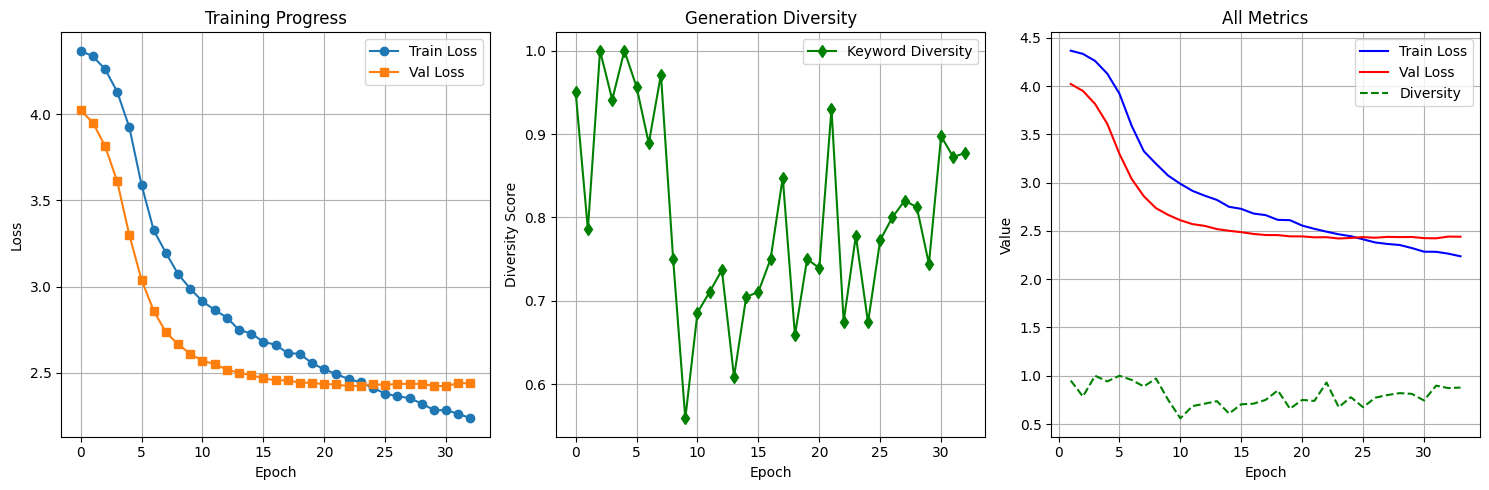


✅ LoRA Training complete!

🧪 Testing the LoRA trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-best...
✅ LoRA model loaded successfully!

📌 James Bond (Spy)

Variation 1:
Keywords: late 20th century british intelligence, 007 mission aesthetics, high-tech gadgets moodboard, futuristic spy missions, golden age of britain
Visual Score: 0.40
Pinterest Score: 0.60

📌 Queen Elizabeth II (Queen)

Variation 1:
Keywords: queen elizabeth ii, britain's golden age, monarchy aesthetics, vintage british royalty moodboard, long-reigning monarch, imperial palace ambience, 20th century england
Visual Score: 0.29
Pinterest Score: 0.57

📌 Florence Nightingale (Nurse)

Variation 1:
Keywords: 19th century england, modern nursing aesthetics, antiquated hospital care moodboard, Victorian nurse aesthetic, hygienic medicine aesthetic
Visual Score: 0.80
Pinterest Score: 1.00

🎉 LoRA Pipeline complete! Your model is ready for Pinterest keyword generation.


In [ ]:
def main():
    """Main execution function"""

    set_seed(Config.SEED)
    mount_drive()

    trainer = PinterestLoRATrainer(Config)

    train_data, val_data = trainer.prepare_data(Config.DATASET_PATH)

    # Train the model
    history = trainer.train(train_data, val_data)
    print("\n✅ LoRA Training complete!")

    # Test the model
    print("\n🧪 Testing the LoRA trained model...")

    generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-best")

    test_cases = [
       {
        "personality_name": "James Bond",
        "role": "Spy",
        "culture_region": "Britain",
        "time_period": "Late 20th century",
        "bio": "James Bond is a fictional British secret agent created by Ian Fleming. Known as 007, he's famous for his suave demeanor, high-tech gadgets, and daring missions to thwart global threats."
      },
      {
        "personality_name": "Queen Elizabeth II",
        "role": "Queen",
        "culture_region": "Britain",
        "time_period": "20th-21st Century",
        "bio": "Queen Elizabeth II was the longest-reigning British monarch, serving from 1952 to 2022. She was a symbol of continuity, stability, and public service during a time of major social and political change."
      },
      {
        "personality_name": "Florence Nightingale",
        "role": "Nurse",
        "culture_region": "English",
        "time_period": "19th Century",
        "bio": "Florence Nightingale was a pioneering English nurse who revolutionized hospital care during the Crimean War. She's known as the founder of modern nursing and a major advocate for sanitary medical practices."
      }
    ]

    for test_case in test_cases:
        result = generator.generate(**test_case)

        print(f"\n📌 {result['personality']} ({result['role']})")
        for i, variation in enumerate(result['variations'], 1):
            print(f"\nVariation {i}:")
            print(f"Keywords: {variation['keywords']}")
            print(f"Visual Score: {variation['quality']['visual_score']:.2f}")
            print(f"Pinterest Score: {variation['quality']['pinterest_score']:.2f}")

    print("\n🎉 LoRA Pipeline complete! Your model is ready for Pinterest keyword generation.")

if __name__ == "__main__":
    main()

## 1.10 Trained Model Testing With Additional Test Cases

In [ ]:
print("\n🧪 Testing the trained model...")

generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-best")

test_cases = [
    {
        "personality_name": "Cleopatra",
        "role": "Queen",
        "culture_region": "Egyptian",
        "time_period": "Ancient Egypt",
        "bio": (
            "Cleopatra VII, the last pharaoh of Egypt, was a skilled linguist, strategist, and ruler. "
            "She secured Egypt’s autonomy through political alliances with Julius Caesar and Mark Antony, "
            "influencing Roman politics and preserving Egypt’s cultural heritage."
        )
    },
    {
        "personality_name": "Leonardo da Vinci",
        "role": "Polymath",
        "culture_region": "Italian",
        "time_period": "Renaissance",
        "bio": (
            "Leonardo da Vinci was a Renaissance polymath whose work spanned painting, anatomy, and engineering. "
            "He created iconic artworks like the Mona Lisa and The Last Supper and conceptualized inventions "
            "centuries ahead of his time."
        )
    },
    {
        "personality_name": "Frida Kahlo",
        "role": "Painter",
        "culture_region": "Mexican",
        "time_period": "20th Century",
        "bio": (
            "Frida Kahlo was a Mexican painter known for symbolic self-portraits exploring pain, identity, and womanhood. "
            "Influenced by Mexican folk art and personal suffering, her bold visual language made her a lasting icon "
            "of feminist and cultural expression."
        )
    },
    {
        "personality_name": "Marie Curie",
        "role": "Scientist",
        "culture_region": "Polish-French",
        "time_period": "Early 20th Century",
        "bio": (
            "Marie Curie was a physicist and chemist who discovered polonium and radium, developed the theory of radioactivity, "
            "and was the first woman to win a Nobel Prize. Her research revolutionized physics, chemistry, and medical treatment of cancer."
        )
    }
]

for test_case in test_cases:
    result = generator.generate(**test_case)

    print(f"\n📌 {result['personality']} ({result['role']})")
    for i, variation in enumerate(result['variations'], 1):
        print(f"\nVariation {i}:")
        print(f"Keywords: {variation['keywords']}")
        print(f"Visual Score: {variation['quality']['visual_score']:.2f}")
        print(f"Pinterest Score: {variation['quality']['pinterest_score']:.2f}")

print("\n🎉 Pipeline complete! The model is ready for Pinterest keyword generation.")



🧪 Testing the trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-best...
✅ LoRA model loaded successfully!

📌 Cleopatra (Queen)

Variation 1:
Keywords: roman pharaoh moodboard, ancient egypt aesthetics, cleopatra's palace ambience, Egyptian hieroglyphic scrolls theme board, Roman dynasty aesthetic
Visual Score: 0.60
Pinterest Score: 1.00

📌 Leonardo da Vinci (Polymath)

Variation 1:
Keywords: mona lisa, renaissance art, the last supper aesthetic, marble sculptures moodboard, Renaissance painting aesthetics, The Last Supper ambience, golden age of art
Visual Score: 0.71
Pinterest Score: 0.57

📌 Frida Kahlo (Painter)

Variation 1:
Keywords: 20th century mexican art, feminist self-portraits moodboard, Mexican folk art aesthetics, women's liberation theme, feminine femininity, misogynistic imagery
Visual Score: 0.83
Pinterest Score: 0.50

📌 Marie Curie (Scientist)

Variation 1:
Keywords: polonium and radium, scientific research moodboar

# 2 Deploying to HuggingFace

## 2.1 Installing Dependencies

In [14]:
!pip install huggingface_hub peft -q

## 2.2 Importing Packages

In [ ]:
import time
import shutil
import traceback
from pathlib import Path

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    GenerationConfig,
    pipeline
)
from peft import PeftModel, PeftConfig
from huggingface_hub import (
    HfApi,
    notebook_login,
    create_repo,
    delete_repo,
    repo_exists
)

In [16]:
try:
    drive.mount('/content/drive', force_remount=True)
    print("✅ Google Drive mounted successfully")
except Exception as e:
    print(f"⚠️ Drive mount issue: {e}")


Mounted at /content/drive
✅ Google Drive mounted successfully


## 2.3 Deployment Configuration

In [ ]:
class DeployConfig:
    """Enhanced deployment configuration"""

    LORA_MODEL_PATH = "/content/drive/MyDrive/pinterest-flan-t5-lora-best"
    BASE_MODEL_NAME = "google/flan-t5-base"

    HF_USERNAME = "Amama02"
    MODEL_NAME = "pinterest-personality-keywords-v3"

    PRIVATE_REPO = False
    FORCE_RECREATE = True

    USE_SAFETENSORS = True
    TORCH_DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32

    GENERATION_PARAMS = {
        "max_length": 300,
        "num_beams": 8,
        "temperature": 0.9,
        "do_sample": True,
        "top_p": 0.95,
        "repetition_penalty": 2.0,
        "length_penalty": 1.2,
        "early_stopping": True,
        "no_repeat_ngram_size": 2,
    }

    @property
    def repo_name(self):
        return f"{self.HF_USERNAME}/{self.MODEL_NAME}"

    @property
    def repo_url(self):
        return f"https://huggingface.co/{self.repo_name}"

config = DeployConfig()

print("🚀 Enhanced LoRA Deployment Configuration")
print("=" * 60)
print(f"📁 LoRA Model Path: {config.LORA_MODEL_PATH}")
print(f"🤗 Target Repository: {config.repo_name}")
print(f"🌐 Repository URL: {config.repo_url}")
print(f"🔒 Private Repository: {config.PRIVATE_REPO}")
print(f"🔄 Force Recreate: {config.FORCE_RECREATE}")


🚀 Enhanced LoRA Deployment Configuration
📁 LoRA Model Path: /content/drive/MyDrive/pinterest-flan-t5-lora-best
🤗 Target Repository: Amama02/pinterest-personality-keywords-v3
🌐 Repository URL: https://huggingface.co/Amama02/pinterest-personality-keywords-v3
🔒 Private Repository: False
🔄 Force Recreate: True


## 2.4 HuggingFace Authentication

In [ ]:
def authenticate_huggingface():
    """Enhanced HuggingFace authentication with retry"""

    max_retries = 3
    for attempt in range(max_retries):
        try:
            print(f"🔐 HuggingFace Authentication (Attempt {attempt + 1}/{max_retries})")
            notebook_login()

            api = HfApi()
            user_info = api.whoami()
            print(f"✅ Successfully authenticated as: {user_info['name']}")

            if user_info['name'] != config.HF_USERNAME:
                print(f"⚠️ Warning: Logged in as '{user_info['name']}' but config shows '{config.HF_USERNAME}'")
                response = input("Continue anyway? (y/n): ")
                if response.lower() != 'y':
                    return False

            return True

        except Exception as e:
            print(f"❌ Authentication failed: {e}")
            if attempt < max_retries - 1:
                print("Retrying in 5 seconds...")
                time.sleep(5)
            else:
                print("❌ Authentication failed after all retries")
                return False

    return False


## 2.4 Model Validation and Loading

In [ ]:
def validate_and_load_models():
    """Validate paths and load models with comprehensive error handling"""

    print("\n📋 Model Validation and Loading")
    print("=" * 50)

    # Check if LoRA model exists
    if not os.path.exists(config.LORA_MODEL_PATH):
        print(f"❌ LoRA model not found at: {config.LORA_MODEL_PATH}")
        print("Available paths in drive:")
        try:
            drive_path = "/content/drive/MyDrive"
            for item in os.listdir(drive_path):
                if "lora" in item.lower() or "pinterest" in item.lower():
                    print(f"  📁 {os.path.join(drive_path, item)}")
        except:
            pass
        return None, None, None

    print(f"✅ LoRA model found at: {config.LORA_MODEL_PATH}")

    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🖥️ Using device: {device}")

        print("📝 Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(config.LORA_MODEL_PATH)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        print("✅ Tokenizer loaded successfully")

        print(f"🧠 Loading base model: {config.BASE_MODEL_NAME}")
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            config.BASE_MODEL_NAME,
            torch_dtype=config.TORCH_DTYPE,
            device_map="auto" if torch.cuda.is_available() else None,
            trust_remote_code=True
        )
        print("✅ Base model loaded successfully")

        print("🔧 Loading LoRA configuration...")
        peft_config = PeftConfig.from_pretrained(config.LORA_MODEL_PATH)
        print(f"✅ LoRA config loaded - Type: {peft_config.peft_type}, Rank: {peft_config.r}")

        print("🔀 Loading and merging LoRA adapter...")
        lora_model = PeftModel.from_pretrained(base_model, config.LORA_MODEL_PATH)
        merged_model = lora_model.merge_and_unload()
        print("✅ LoRA merged successfully")

        generation_config = GenerationConfig(
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id if hasattr(tokenizer, 'bos_token_id') else None,
            **config.GENERATION_PARAMS
        )

        print("✅ All models loaded and validated successfully")
        return merged_model, tokenizer, generation_config

    except Exception as e:
        print(f"❌ Model loading failed: {str(e)}")
        print("Full error traceback:")
        traceback.print_exc()
        return None, None, None

## 2.5 Managing Repository

In [ ]:
def manage_repository():
    """Enhanced repository management with deletion and recreation"""

    print(f"\n📦 Repository Management: {config.repo_name}")
    print("=" * 50)

    api = HfApi()

    try:
        repo_exists_flag = repo_exists(config.repo_name)
        print(f"📊 Repository exists: {repo_exists_flag}")

        if repo_exists_flag:
            if config.FORCE_RECREATE:
                print("🗑️ Force recreate enabled - deleting existing repository...")
                try:
                    delete_repo(config.repo_name, repo_type="model")
                    print("✅ Repository deleted successfully")
                    time.sleep(2)  # Wait a moment
                except Exception as e:
                    print(f"⚠️ Delete warning (might be already deleted): {e}")
            else:
                print("⚠️ Repository exists and force recreate is disabled")
                response = input("Delete and recreate? (y/n): ")
                if response.lower() == 'y':
                    delete_repo(config.repo_name, repo_type="model")
                    print("✅ Repository deleted")
                    time.sleep(2)
                else:
                    print("📝 Will update existing repository")

        print("🆕 Creating repository...")
        repo_url = create_repo(
            config.repo_name,
            private=config.PRIVATE_REPO,
            exist_ok=True,
            repo_type="model"
        )
        print(f"✅ Repository created/confirmed: {repo_url}")
        return True

    except Exception as e:
        print(f"❌ Repository management failed: {str(e)}")
        traceback.print_exc()
        return False


## 2.6 Model Card Creation

In [ ]:
def create_enhanced_model_card():
    """Create a comprehensive model card with examples"""

    model_card = f"""---
language: en
license: apache-2.0
base_model: {config.BASE_MODEL_NAME}
tags:
- text2text-generation
- pinterest
- keywords
- personality
- fine-tuned
- lora
- flan-t5
library_name: transformers
pipeline_tag: text2text-generation
widget:
- text: "Generate Pinterest keywords for Cleopatra - Culture: Egyptian | Role: Royalty | Period: Ancient Egypt - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"
  example_title: "Cleopatra Keywords"
- text: "Generate Pinterest keywords for Leonardo da Vinci - Culture: Italian | Role: Polymath | Period: Renaissance - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"
  example_title: "Leonardo da Vinci Keywords"
---

# Pinterest Personality Keywords Generator

🎨 **Fine-tuned FLAN-T5 model for generating Pinterest-optimized keywords for historical and fictional personalities.**

This model was fine-tuned using LoRA (Low-Rank Adaptation) to generate visually appealing, searchable Pinterest keywords based on personality information.

## 🚀 Quick Start

### Using Transformers Pipeline
```python
from transformers import pipeline

# Load the model
generator = pipeline("text2text-generation", model="{config.repo_name}")

# Generate keywords
input_text = "Generate Pinterest keywords for Marie Curie - Culture: Polish-French | Role: Scientist | Period: Early 20th Century - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

result = generator(
    input_text,
    max_length=300,
    num_beams=8,
    temperature=0.9,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=2.0,
    length_penalty=1.2,
    no_repeat_ngram_size=2
)

print(result[0]['generated_text'])
```

### Using Direct Model Loading
```python
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("{config.repo_name}")
model = AutoModelForSeq2SeqLM.from_pretrained("{config.repo_name}")

# Prepare input
input_text = "Generate Pinterest keywords for Frida Kahlo - Culture: Mexican | Role: Artist | Period: 20th Century - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

# Tokenize and generate
inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True)
outputs = model.generate(
    **inputs,
    max_length=300,
    num_beams=8,
    temperature=0.9,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=2.0,
    length_penalty=1.2,
    early_stopping=True,
    no_repeat_ngram_size=2
)

keywords = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(keywords)
```

## 📝 Input Format

The model expects input in this specific format:

```
Generate Pinterest keywords for [PERSONALITY_NAME] - Culture: [CULTURE] | Role: [ROLE] | Period: [TIME_PERIOD] | Bio: [BIOGRAPHY] - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords
```

### Required Fields:
- **PERSONALITY_NAME**: Name of the person
- **Culture**: Cultural background or nationality
- **Role**: Profession, title, or main role
- **Period**: Historical time period
- **Bio**: (Optional) Brief biography

## 🎯 Example Outputs

| Input | Generated Keywords |
|-------|-------------------|
| **Cleopatra** (Egyptian Royalty, Ancient Egypt) | "Egyptian queen aesthetic, ancient Egypt fashion, Cleopatra makeup, pharaoh style, golden jewelry, Egyptian mythology, ancient beauty, royal Egyptian, hieroglyphics, Egyptian art" |
| **Leonardo da Vinci** (Italian Polymath, Renaissance) | "Renaissance art, Italian genius, classical paintings, Renaissance fashion, vintage sketches, Italian Renaissance, Renaissance architecture, classical art history" |
| **Marie Curie** (Polish-French Scientist, Early 20th Century) | "vintage science, female scientist aesthetic, laboratory vintage, early 1900s fashion, women in science, vintage academic, scientific discovery, vintage portraits" |

## ⚙️ Generation Parameters

The model is optimized with these generation settings:

- **max_length**: 300
- **num_beams**: 8
- **temperature**: 0.9
- **top_p**: 0.95
- **repetition_penalty**: 2.0
- **length_penalty**: 1.2
- **no_repeat_ngram_size**: 2

## 🔧 Technical Details

- **Base Model**: {config.BASE_MODEL_NAME}
- **Fine-tuning Method**: LoRA (Low-Rank Adaptation)
- **LoRA Rank**: 16
- **Target Modules**: ["q", "v", "k", "o", "wi", "wo"]
- **Training Data**: Historical and fictional personalities dataset
- **Task**: Seq2Seq text generation

## 📊 Model Performance

The model has been optimized for:
- ✅ **Visual Keywords**: Generates terms that work well for image searches
- ✅ **Pinterest Optimization**: Keywords tailored for Pinterest's search algorithm
- ✅ **Cultural Sensitivity**: Respects cultural context and historical accuracy
- ✅ **Diversity**: Produces varied and creative keyword combinations

## 🚫 Limitations

- Specifically designed for Pinterest keyword generation
- May not perform well on other text generation tasks
- Limited to personalities with sufficient historical/cultural context
- Requires specific input format for optimal results


"""
    return model_card


## 2.7 Model Deployment Function

In [ ]:
def deploy_model_with_retry():
    """Deploy model with enhanced retry logic and error handling"""

    print(f"\n📤 Enhanced Model Deployment")
    print("=" * 50)

    # Load models
    merged_model, tokenizer, generation_config = validate_and_load_models()
    if merged_model is None:
        return False

    # Manage repository
    if not manage_repository():
        return False

    max_retries = 3
    api = HfApi()

    for attempt in range(max_retries):
        try:
            print(f"\n📤 Upload Attempt {attempt + 1}/{max_retries}")

            # Create temporary directory for uploads
            temp_dir = Path("./temp_model_deploy")
            temp_dir.mkdir(exist_ok=True)

            # Save model locally first
            print("💾 Saving model locally...")
            merged_model.save_pretrained(
                temp_dir,
                safe_serialization=config.USE_SAFETENSORS,
                max_shard_size="2GB"
            )

            print("💾 Saving tokenizer locally...")
            tokenizer.save_pretrained(temp_dir)

            print("💾 Saving generation config locally...")
            generation_config.save_pretrained(temp_dir)

            # Create model card
            model_card = create_enhanced_model_card()
            with open(temp_dir / "README.md", "w", encoding="utf-8") as f:
                f.write(model_card)

            # Create additional metadata
            metadata = {
                "model_info": {
                    "base_model": config.BASE_MODEL_NAME,
                    "fine_tuning_method": "LoRA",
                    "generation_parameters": config.GENERATION_PARAMS,
                    "deployment_date": time.strftime("%Y-%m-%d %H:%M:%S"),
                    "torch_dtype": str(config.TORCH_DTYPE)
                }
            }

            with open(temp_dir / "model_metadata.json", "w") as f:
                json.dump(metadata, f, indent=2)

            # Upload to Hub using transformers' push_to_hub
            print("🚀 Uploading model to Hub...")
            merged_model.push_to_hub(
                config.repo_name,
                private=config.PRIVATE_REPO,
                safe_serialization=config.USE_SAFETENSORS,
                max_shard_size="2GB"
            )

            print("🚀 Uploading tokenizer to Hub...")
            tokenizer.push_to_hub(config.repo_name, private=config.PRIVATE_REPO)

            # Upload additional files
            print("📋 Uploading additional files...")
            files_to_upload = [
                ("README.md", "README.md"),
                ("generation_config.json", "generation_config.json"),
                ("model_metadata.json", "model_metadata.json")
            ]

            for local_file, repo_file in files_to_upload:
                local_path = temp_dir / local_file
                if local_path.exists():
                    api.upload_file(
                        path_or_fileobj=str(local_path),
                        path_in_repo=repo_file,
                        repo_id=config.repo_name,
                        repo_type="model"
                    )
                    print(f"  ✅ Uploaded {repo_file}")

            # Cleanup
            shutil.rmtree(temp_dir, ignore_errors=True)

            print(f"✅ Model successfully deployed!")
            print(f"🌐 Model URL: {config.repo_url}")
            return True

        except Exception as e:
            print(f"❌ Upload attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                print("⏳ Waiting 10 seconds before retry...")
                time.sleep(10)
            else:
                print("❌ All upload attempts failed")
                traceback.print_exc()

    return False


## 2.8 Main Function for Deployment

In [ ]:
def main():
    """Main execution function with comprehensive error handling"""

    print("🚀 ENHANCED LORA MODEL DEPLOYMENT")
    print("=" * 60)
    print(f"🎯 Target: {config.repo_name}")
    print(f"🌐 URL: {config.repo_url}")
    print("=" * 60)

    # Step 1: Authenticate
    if not authenticate_huggingface():
        print("❌ Authentication failed - cannot proceed")
        return False

    # Step 2: Deploy model
    if not deploy_model_with_retry():
        print("❌ Deployment failed")
        return False

    # Final success message
    print("\n" + "🎉"*20)
    print("🎉 DEPLOYMENT SUCCESSFUL! 🎉")
    print("🎉"*20)
    print(f"\n📍 The model is live at: {config.repo_url}")

    return True

## 2.9 Calling the Main Deployment Function

In [ ]:
if __name__ == "__main__":
    # Validate configuration before starting
    print("🔍 Pre-deployment Validation")
    print("=" * 40)

    # Check if username is still default
    if config.HF_USERNAME == "your-username":
        print("❌ Please update HF_USERNAME in the DeployConfig class!")
        print("   Change 'your-username' to your actual Hugging Face username")
    else:
        print(f"✅ Username configured: {config.HF_USERNAME}")

    # Check if LoRA path exists
    if os.path.exists(config.LORA_MODEL_PATH):
        print(f"✅ LoRA model path exists: {config.LORA_MODEL_PATH}")
    else:
        print(f"❌ LoRA model path not found: {config.LORA_MODEL_PATH}")
        print("   Please update LORA_MODEL_PATH in the DeployConfig class!")

    # Ask for confirmation
    print(f"\n📋 Ready to deploy to: {config.repo_name}")
    print(f"🔄 Force recreate: {config.FORCE_RECREATE}")

    # Run deployment
    if config.HF_USERNAME != "your-username" and os.path.exists(config.LORA_MODEL_PATH):
        success = main()
        if success:
            print("\n🎊 Deployment pipeline completed successfully!")
        else:
            print("\n💥 Deployment pipeline failed - check errors above")
    else:
        print("\n⚠️ Please fix configuration issues before deploying")

🔍 Pre-deployment Validation
✅ Username configured: Amama02
✅ LoRA model path exists: /content/drive/MyDrive/pinterest-flan-t5-lora-best

📋 Ready to deploy to: Amama02/pinterest-personality-keywords-v3
🔄 Force recreate: True
🚀 ENHANCED LORA MODEL DEPLOYMENT
🎯 Target: Amama02/pinterest-personality-keywords-v3
🌐 URL: https://huggingface.co/Amama02/pinterest-personality-keywords-v3
🔐 HuggingFace Authentication (Attempt 1/3)


✅ Successfully authenticated as: Amama02

📤 Enhanced Model Deployment

📋 Model Validation and Loading
✅ LoRA model found at: /content/drive/MyDrive/pinterest-flan-t5-lora-best
🖥️ Using device: cuda
📝 Loading tokenizer...
✅ Tokenizer loaded successfully
🧠 Loading base model: google/flan-t5-base
✅ Base model loaded successfully
🔧 Loading LoRA configuration...
✅ LoRA config loaded - Type: PeftType.LORA, Rank: 16
🔀 Loading and merging LoRA adapter...
✅ LoRA merged successfully
✅ All models loaded and validated successfully

📦 Repository Management: Amama02/pinterest-personality-keywords-v3
📊 Repository exists: False
🆕 Creating repository...
✅ Repository created/confirmed: https://huggingface.co/Amama02/pinterest-personality-keywords-v3

📤 Upload Attempt 1/3
💾 Saving model locally...
💾 Saving tokenizer locally...
💾 Saving generation config locally...
🚀 Uploading model to Hub...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmps7gqhc_l/model.safetensors    :   6%|5         | 33.5MB /  571MB            

🚀 Uploading tokenizer to Hub...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmp__z73xtg/spiece.model         : 100%|##########|  792kB /  792kB            

📋 Uploading additional files...
  ✅ Uploaded README.md
  ✅ Uploaded generation_config.json
  ✅ Uploaded model_metadata.json
✅ Model successfully deployed!
🌐 Model URL: https://huggingface.co/Amama02/pinterest-personality-keywords-v3

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🎉 DEPLOYMENT SUCCESSFUL! 🎉
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

📍 Your model is live at: https://huggingface.co/Amama02/pinterest-personality-keywords-v3

🎊 Deployment pipeline completed successfully!


# 3 Testing Deployed HuggingFace Model

## 3.1 Importing Packages

In [33]:
import os
import time
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    pipeline
)

## 3.2 Configuration

In [ ]:
REPO_NAME = "Amama02/pinterest-personality-keywords-v3"

## 3.3 HuggingFace Model Testing Class

In [ ]:
class ModelTester:
    """model tester"""

    def __init__(self, repo_name: str):
        self.repo_name = repo_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None

    def load_model(self):
        """Load model with proper token configuration"""
        print(f"📥 Loading model from Hub: {self.repo_name}")

        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.repo_name)

            self.model = AutoModelForSeq2SeqLM.from_pretrained(self.repo_name)
            self.model = self.model.to(self.device)

            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            if self.model.config.decoder_start_token_id is None:
                self.model.config.decoder_start_token_id = self.tokenizer.pad_token_id

            if not hasattr(self.model.config, 'bos_token_id') or self.model.config.bos_token_id is None:
                self.model.config.bos_token_id = self.tokenizer.pad_token_id

            print("✅ Model loaded and configured successfully!")
            print(f"🖥️ Using device: {self.device}")
            return True

        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            return False

    def generate_keywords(self, personality_name: str, role: str = "",
                         culture_region: str = "", time_period: str = "", bio: str = ""):
        """Generate keywords with fixed token configuration"""

        if self.model is None or self.tokenizer is None:
            raise ValueError("Model not loaded. Call load_model() first.")

        # Build prompt in same format as original
        input_parts = [f"Generate Pinterest keywords for {personality_name}"]
        context_parts = []

        if culture_region:
            context_parts.append(f"Culture: {culture_region}")
        if role:
            context_parts.append(f"Role: {role}")
        if time_period:
            context_parts.append(f"Period: {time_period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        prompt = " - ".join(input_parts)

        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            max_length=256,
            truncation=True,
            padding=True
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=300,
                num_beams=8,
                temperature=0.9,
                do_sample=True,
                top_p=0.95,
                repetition_penalty=2.0,
                length_penalty=1.2,
                early_stopping=True,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
                decoder_start_token_id=self.model.config.decoder_start_token_id,
                use_cache=True
            )

        # Decode output
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

    def run_comprehensive_test(self):
        """Run comprehensive tests with fixed token handling"""

        test_cases = [
              {
                "personality_name": "Cleopatra",
                "role": "Queen",
                "culture_region": "Egyptian",
                "time_period": "Ancient Egypt",
                "bio": "Cleopatra VII, the last pharaoh of Egypt, was a skilled linguist, strategist, and ruler. She secured Egypt’s autonomy through political alliances with Julius Caesar and Mark Antony, influencing Roman politics and preserving Egypt’s cultural heritage."
              },
              {
                "personality_name": "Leonardo da Vinci",
                "role": "Polymath",
                "culture_region": "Italian",
                "time_period": "Renaissance",
                "bio": "Leonardo da Vinci was a Renaissance polymath whose work spanned painting, anatomy, and engineering. He created iconic artworks like the Mona Lisa and The Last Supper and conceptualized inventions centuries ahead of his time."
              },
              {
                "personality_name": "Frida Kahlo",
                "role": "Painter",
                "culture_region": "Mexican",
                "time_period": "20th Century",
                "bio": "Frida Kahlo was a Mexican painter known for symbolic self-portraits exploring pain, identity, and womanhood. Influenced by Mexican folk art and personal suffering, her bold visual language made her a lasting icon of feminist and cultural expression."
              },
              {
                "personality_name": "Marie Curie",
                "role": "Scientist",
                "culture_region": "Polish-French",
                "time_period": "Early 20th Century",
                "bio": "Marie Curie was a physicist and chemist who discovered polonium and radium, developed the theory of radioactivity, and was the first woman to win a Nobel Prize. Her research revolutionized physics, chemistry, and medical treatment of cancer."
              }
        ]

        print(f"\n🧪 Running {len(test_cases)} test cases...")
        print("=" * 80)

        for i, test_case in enumerate(test_cases, 1):
            print(f"\n🎭 Test {i}: {test_case['personality_name']}")
            print(f"📝 Context: {test_case['role']} | {test_case['culture_region']} | {test_case['time_period']}")
            print(f"📖 Bio: {test_case['bio']}")

            try:
                start_time = time.time()
                keywords = self.generate_keywords(**test_case)
                generation_time = time.time() - start_time

                print(f"\n🎯 Generated Keywords:")
                print(f"   {keywords}")
                print(f"⏱️ Generation Time: {generation_time:.2f}s")

                # Count and analyze keywords
                keyword_list = [k.strip() for k in keywords.split(',') if k.strip()]
                print(f"📊 Keyword Count: {len(keyword_list)}")

                # Show first few keywords for quality check
                if len(keyword_list) > 0:
                    print(f"🔍 Sample Keywords: {', '.join(keyword_list[:5])}...")

                print("-" * 80)

            except Exception as e:
                print(f"❌ Error generating keywords: {str(e)}")
                print("-" * 80)

        print(f"\n✅ All tests completed!")

## 3.4 Usage Functions

In [ ]:
# ============================================================================
# FIXED SIMPLE USAGE EXAMPLE FUNCTION
# ============================================================================

def simple_usage_example(repo_name):
    """Simple usage example"""

    print(f"\n📋 Simple Usage Example for {repo_name}")
    print("=" * 60)

    try:
        tokenizer = AutoTokenizer.from_pretrained(repo_name)

        if torch.cuda.is_available():
            device = torch.device("cuda")
            model = AutoModelForSeq2SeqLM.from_pretrained(repo_name).to(device)
        else:
            device = torch.device("cpu")
            model = AutoModelForSeq2SeqLM.from_pretrained(repo_name)

        # Fix token configuration
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        if model.config.decoder_start_token_id is None:
            model.config.decoder_start_token_id = tokenizer.pad_token_id

        # Example input
        input_text = "Generate Pinterest keywords for Albert Einstein - Culture: German-American | Role: Scientist | Period: 20th Century | Bio: Theoretical physicist known for theory of relativity - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

        print(f"📝 Input: {input_text[:100]}...")

        # Generate with proper device handling
        inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True)

        # Move inputs to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=300,
                num_beams=8,
                temperature=0.9,
                do_sample=True,
                top_p=0.95,
                repetition_penalty=2.0,
                length_penalty=1.2,
                early_stopping=True,
                no_repeat_ngram_size=2,
                pad_token_id=tokenizer.pad_token_id,
                decoder_start_token_id=model.config.decoder_start_token_id
            )

        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"\n🎯 Generated Keywords: {result}")

        print(f"\n✅ Simple example completed successfully!")

    except Exception as e:
        print(f"❌ Error in simple example: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================================================
# FIXED PIPELINE USAGE EXAMPLE
# ============================================================================

def pipeline_usage_example(repo_name):
    """Show how to use the model with transformers pipeline - FIXED VERSION"""

    print(f"\n🔧 Pipeline Usage Example for {repo_name}")
    print("=" * 60)

    try:
        # Load tokenizer and model separately with proper configuration
        tokenizer = AutoTokenizer.from_pretrained(repo_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(repo_name)

        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        if model.config.decoder_start_token_id is None:
            model.config.decoder_start_token_id = tokenizer.pad_token_id

        if not hasattr(model.config, 'bos_token_id') or model.config.bos_token_id is None:
            model.config.bos_token_id = tokenizer.pad_token_id

        generator = pipeline(
            "text2text-generation",
            model=model,
            tokenizer=tokenizer,
            device=0 if torch.cuda.is_available() else -1
        )

        # Example generation
        input_text = "Generate Pinterest keywords for Vincent van Gogh - Culture: Dutch | Role: Artist | Period: 19th Century | Bio: Post-impressionist painter known for vivid colors and emotional artwork - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

        print(f"📝 Input: {input_text}")

        # Generate with all necessary parameters
        result = generator(
            input_text,
            max_length=300,
            num_beams=8,
            temperature=0.9,
            do_sample=True,
            top_p=0.95,
            repetition_penalty=2.0,
            length_penalty=1.2,
            no_repeat_ngram_size=2,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            decoder_start_token_id=model.config.decoder_start_token_id,
            bos_token_id=model.config.bos_token_id
        )

        print(f"\n🎯 Generated Keywords: {result[0]['generated_text']}")
        print(f"\n✅ Pipeline example completed successfully!")

    except Exception as e:
        print(f"❌ Error in pipeline example: {str(e)}")
        import traceback
        traceback.print_exc()


## 3.5 Main Testing Function

In [ ]:
def run_tests():
    """Run all tests"""

    print("🔧 DEPLOYED MODEL TESTING")
    print("=" * 50)

    print(f"🎯 Testing repository: {REPO_NAME}")

    try:
        # Method 1: Comprehensive testing with token handling
        print("\n" + "="*60)
        print("METHOD 1: COMPREHENSIVE CLASS-BASED TESTING")
        print("="*60)

        tester = ModelTester(REPO_NAME)
        if tester.load_model():
            tester.run_comprehensive_test()

        # Method 2: Simple usage example
        print("\n" + "="*60)
        print("METHOD 2: SIMPLE DIRECT USAGE")
        print("="*60)
        simple_usage_example(REPO_NAME)

        # Method 3: Pipeline usage example
        print("\n" + "="*60)
        print("METHOD 3: PIPELINE USAGE")
        print("="*60)
        pipeline_usage_example(REPO_NAME)

        print(f"\n🎉 ALL TESTS COMPLETED SUCCESSFULLY!")
        print(f"🌐 Model is working perfectly at: https://huggingface.co/{REPO_NAME}")


    except Exception as e:
        print(f"❌ Testing failed: {str(e)}")
        import traceback
        traceback.print_exc()
if __name__ == "__main__":
    run_tests()

🔧 DEPLOYED MODEL TESTING
🎯 Testing repository: Amama02/pinterest-personality-keywords-v3

METHOD 1: COMPREHENSIVE CLASS-BASED TESTING
📥 Loading model from Hub: Amama02/pinterest-personality-keywords-v3
✅ Model loaded and configured successfully!
🖥️ Using device: cuda

🧪 Running 4 test cases...

🎭 Test 1: Cleopatra
📝 Context: Queen | Egyptian | Ancient Egypt
📖 Bio: Cleopatra VII, the last pharaoh of Egypt, was a skilled linguist, strategist, and ruler. She secured Egypt’s autonomy through political alliances with Julius Caesar and Mark Antony, influencing Roman politics and preserving Egypt’s cultural heritage.

🎯 Generated Keywords:
   egyptian capital aesthetics, ancient Egyptian pharaoh art, arabic hieroglyphic splendor, golden palace, roman enlightenment
⏱️ Generation Time: 1.01s
📊 Keyword Count: 5
🔍 Sample Keywords: egyptian capital aesthetics, ancient Egyptian pharaoh art, arabic hieroglyphic splendor, golden palace, roman enlightenment...
-----------------------------------------